In [1]:
import pandas as pd
import numpy as np
import os
import cv2
import sys
import math
import matplotlib
import scipy
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import seaborn as sns
from tifffile import imread
from glob import glob
from scipy.stats import mode
from collections import Counter
import math
import skimage
import re
from itertools import chain
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from functools import partial
import matplotlib.animation as animation
import networkx as nx
from tifffile import imread

sys.path.append("./")
import analysis as an
from importlib import reload

In [2]:
# quantify the first image

imDir = "/scratch/indikar_root/indikar1/cstansbu/tgfb_wound/images/"

exps = ['A1', 'A2', 'A3', 'B1', 'B2', 'B3']

time = None
images = {}
segments = {}

for f in os.listdir(imDir):
    fullpath = f"{imDir}{f}"
    imId = f.split(".")[0]
    num = re.sub("[^0-9]", "", imId)
    geo = re.sub("[^a-zA-Z]", "", imId)

    if not imId in exps:
        continue
    
    if "processed" in f:
        im = imread(fullpath, key=time)
        print(f"{f} {im.shape=}")
        images[imId] = im

    if "segmented" in f:
        im = imread(fullpath, key=time)
        print(f"{f} {im.shape=}")
        segments[imId] = im
    
print('done')

A2.processed.tiff im.shape=(3, 97, 1510, 913)
B2.segmented.tiff im.shape=(97, 1511, 914)
B1.segmented.tiff im.shape=(97, 1510, 913)
A2.segmented.tiff im.shape=(97, 1510, 913)
B3.segmented.tiff im.shape=(97, 1511, 914)
A1.segmented.tiff im.shape=(97, 1511, 914)
B3.processed.tiff im.shape=(3, 97, 1511, 914)
B1.processed.tiff im.shape=(3, 97, 1510, 913)
A3.processed.tiff im.shape=(3, 97, 1511, 914)
A1.processed.tiff im.shape=(3, 97, 1511, 914)
A3.segmented.tiff im.shape=(97, 1511, 914)
B2.processed.tiff im.shape=(3, 97, 1511, 914)
done


48hr
<class 'list'>


Text(0.5, 1.0, 'B1 (48hr)')

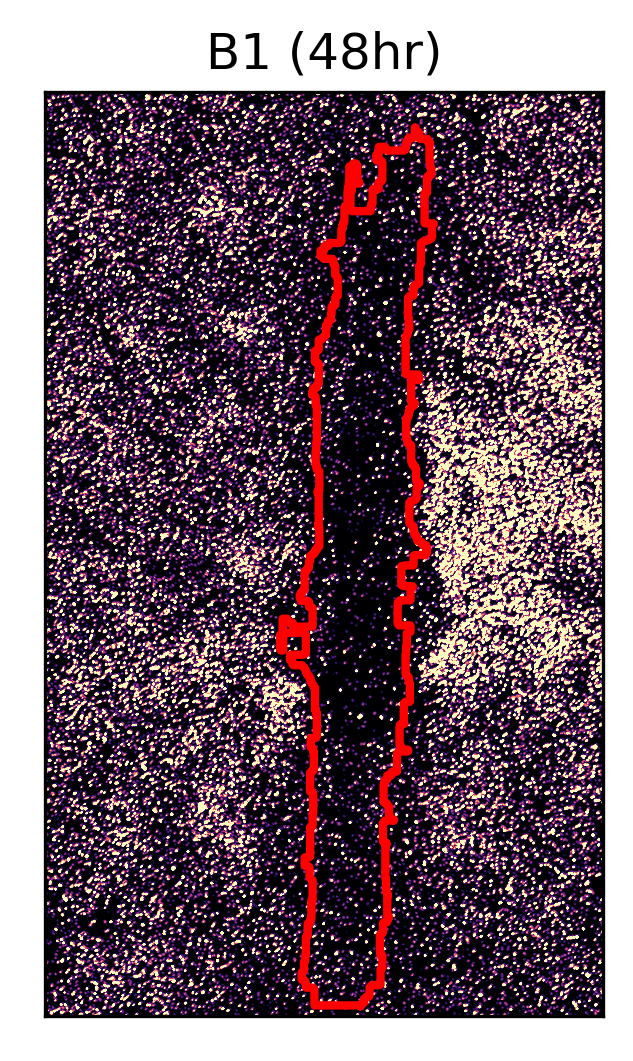

In [25]:
reload(an)

time = 96
channel = 0

imId = "B1"
img = images[imId][channel, time, : :]
seg = segments[imId][time, :, :]

foot = skimage.morphology.square
t = 3
q = 4
dilation = [30]
wound = an.get_wound_area(img, foot, t, q, dilation)
# contours = skimage.measure.find_contours(wound)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 4
fig, ax = plt.subplots()

ax.imshow(img, 
          cmap="magma", 
          vmin=0, 
          vmax=30)

ax.set_xticks([])
ax.set_yticks([])
print(f"{int((time * 30) / 60)}hr")
# timeString = "{" + f"{int((time * 30) / 60)}" "}" 
# ax.set_title(rf'Line Wound $t_{timeString}$')

for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2, color='r')

print(type(contours))

plt.title(f"{imId} ({int((time * 30) / 60)}hr)")


In [4]:
# get change in  wound area over time

foot = skimage.morphology.square
t = 1
q = 4
dilation = [25]

# time samling
start = 10
end = 90
nstep = 90

times = np.linspace(start, end, nstep, dtype='int')
channel = 0

res = []

for imId in exps:
    for time in times:
        img = images[imId][channel, time, :, :]
        wound = an.get_wound_area(img, foot, t, q, dilation)
        contours = skimage.measure.find_contours(wound)

        row = {
            'imId' : imId,
            'time' : time,
            'hours' : (time * 30) / 60,
            'wound_size' : np.sum(wound),
            'wound_perc' : np.sum(wound) / wound.size,
            'contours' : contours,
        }
        res.append(row)

res = pd.DataFrame(res)
res.head()

,imId,time,hours,wound_size,wound_perc,contours
0,A1,10,5.0,201548,0.145938,"[[[1510.0, 358.5], [1509.0, 358.5], [1508.0, 3..."
1,A1,10,5.0,201548,0.145938,"[[[1510.0, 358.5], [1509.0, 358.5], [1508.0, 3..."
2,A1,11,5.5,198377,0.143642,"[[[1510.0, 359.5], [1509.0, 359.5], [1508.0, 3..."
3,A1,12,6.0,195048,0.141231,"[[[1510.0, 361.5], [1509.0, 361.5], [1508.0, 3..."
4,A1,13,6.5,191860,0.138923,"[[[1510.0, 362.5], [1509.0, 362.5], [1508.0, 3..."


Text(0.5, 0, 'Time (hr)')

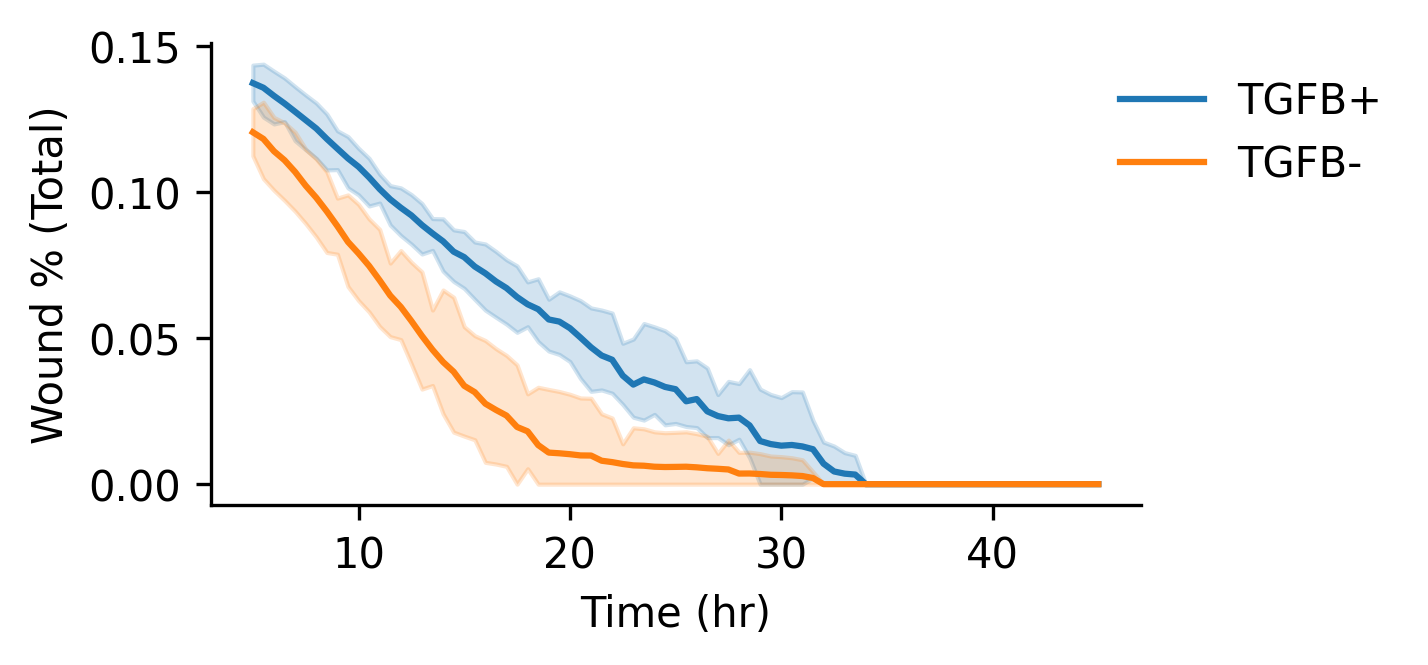

In [9]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 2

pdf = res.copy()

shapeMap = {
    "A1" : "TGFB+",
    "A2" : "TGFB+",
    "A3" : "TGFB+",
    "B1" : "TGFB-",
    "B2" : "TGFB-",
    "B3" : "TGFB-",
}

pdf['wound_shape'] = pdf['imId'].map(shapeMap)

sns.lineplot(data=pdf, 
             x='hours',
             y='wound_perc',
             hue='wound_shape',
             lw=1.5)

sns.despine()
sns.move_legend(plt.gca(), 
                loc='upper right',
                frameon=False,
                title="",
                bbox_to_anchor=(1.3, 1),
                )

plt.ylabel("Wound % (Total)")
plt.xlabel("Time (hr)")

Text(0.5, 0, 'Time (hr)')

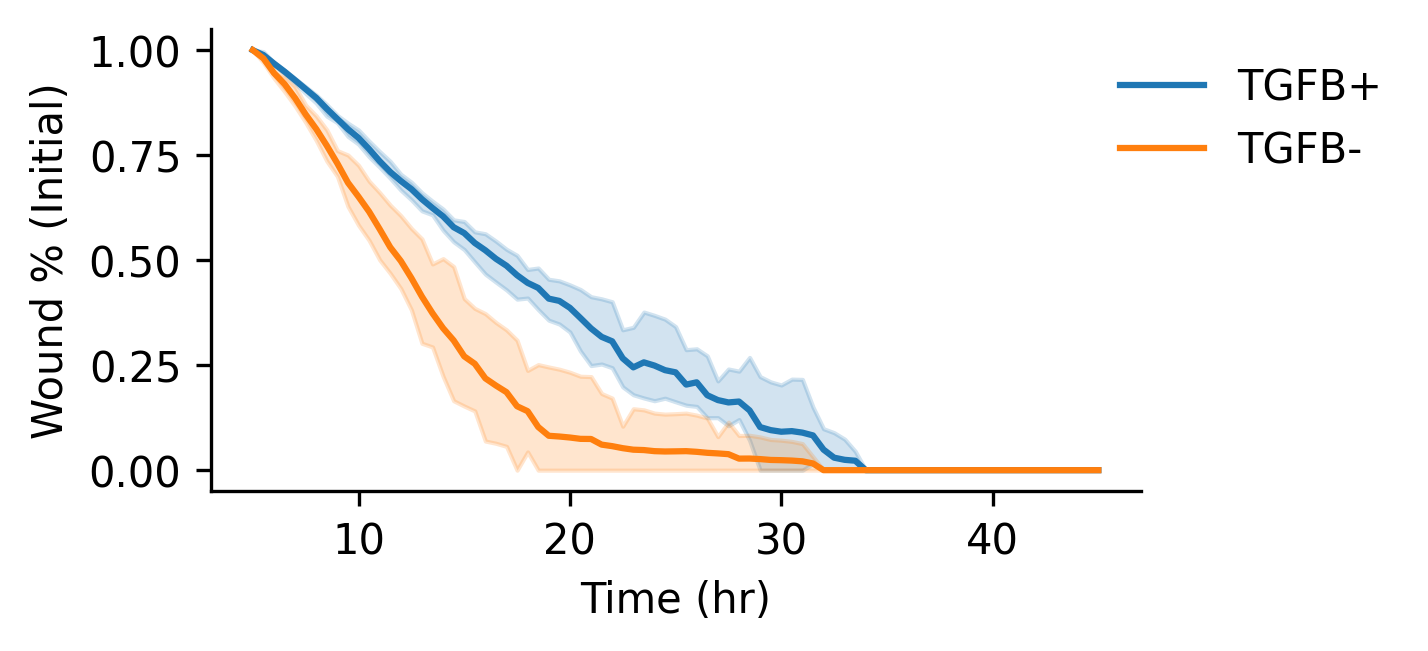

In [27]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 2

pdf = res.copy()

shapeMap = {
    "A1" : "TGFB+",
    "A2" : "TGFB+",
    "A3" : "TGFB+",
    "B1" : "TGFB-",
    "B2" : "TGFB-",
    "B3" : "TGFB-",
}

pdf['wound_shape'] = pdf['imId'].map(shapeMap)
pdf['wound_max'] = pdf.groupby(['imId'])['wound_size'].transform('max')
pdf['wound_perc_of_max'] = pdf['wound_size'] / pdf['wound_max']

sns.lineplot(data=pdf, 
             x='hours',
             y='wound_perc_of_max',
             hue='wound_shape',
             lw=1.5,)

sns.despine()
sns.move_legend(plt.gca(), 
                loc='upper right',
                frameon=False,
                title="",
                bbox_to_anchor=(1.3, 1),
                )

plt.ylabel("Wound % (Initial)")
plt.xlabel("Time (hr)")